# Pairs Trading 

### Notebook by [Marco Tavora](https://marcotavora.me/)

## Table of contents

1. [What is Pairs Trading?](#What-is-Pairs-Trading)
2. [Importing modules](#Importing-modules)
3. [Cointegrated ficticious stocks](#Cointegrated-ficticious-stocks)

## What is Pairs Trading?
[[go back to the top]](#Table-of-contents)

From [Wiki](https://en.wikipedia.org/wiki/Pairs_trade):
> Pair trading is a market neutral trading strategy enabling traders to profit from virtually any market conditions: uptrend, downtrend, or sideways movement. This strategy is categorized as a statistical arbitrage and convergence trading strategy.

Consider a pair of assets $y_{1,t}$ and $y_{2,t}$ historically correlated and having some kind of underlying economic link. For example, $y_{1,t}$ and $y_{2,t}$ could be Pepsi and Coca-Cola stocks.

> When the correlation between the two securities temporarily weakens, i.e. one stock moves up while the other moves down, the pairs trade would be to short the outperforming stock and to long the underperforming one, betting that the "spread" between the two would eventually converge. 

This deviation from equilibrium within a pair can be caused by:
> temporary supply/demand changes, large buy/sell orders for one security, reaction for important news about one of the companies, and so on. [...] Although the strategy does not have much downside risk, there is a scarcity of opportunities, and, for profiting, the trader must be one of the first to capitalize on the opportunity. A notable pairs trader was hedge fund Long-Term Capital Management.

### Quick review: Long and Short Position ([link](https://www.investopedia.com/terms/l/long.asp)):

> With a long position investment, the investor purchases an asset and owns it with the expectation that the price is going to rise. He normally has no plan to sell the security in the near future. A key component of long position investment is the ownership of the stock or bond. 

> This contrasts with the short position investment, where an investor does not own the stock but borrows it with the expectation of selling it and then repurchasing it at a lower price. 


## Importing Python packages
[[go back to the top]](#Table-of-contents)

In [119]:
import statsmodels
import sys
import os


import numpy             as np
import pandas            as pd
import statsmodels.api   as sm
import seaborn           as sns 
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import coint
from datetime                  import datetime
sns.set()
np.random.seed(107)

%matplotlib inline

## Cointegrated ficticious stocks
[[go back to the top]](#Table-of-contents)

Roughly speaking, two time series are cointegrated when there is some linear combination of them which varies around a mean. 

In [18]:
stocks = pd.read_csv('stocks-new.csv')
stocks.index = stocks['time']
stocks = stocks.drop('time', axis=1)
stocks.head()

,y1,y2
time,,
0,48.920467,53.012007
1,49.315086,53.079936
2,49.673521,54.652120
3,49.956942,54.290531
4,49.087898,52.639392


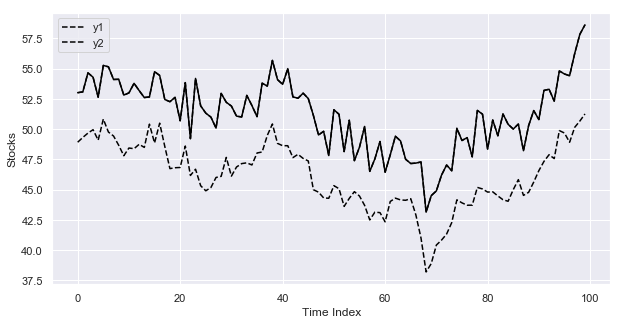

In [19]:
stocks.plot(figsize=(10,5), color='black',  linestyle='--');
plt.plot(stocks['y2'], color='black') 
plt.xlabel('Time Index')
plt.ylabel('Stocks')
plt.show();

## Cointegration tests
[[go back to the top]](#Table-of-contents)

The package `statsmodels` has a test of cointegration called `coint`. From the [docs](https://www.statsmodels.org/dev/generated/statsmodels.tsa.stattools.coint.html), `coint` is a:

> Test for no-cointegration of a univariate equation. The null hypothesis is no cointegration. Variables in y0 and y1 are assumed to be integrated of order 1, I(1). This uses the augmented Engle-Granger two-step cointegration test.

If we choose our confidence level to be $\alpha$ the $p$-value from the test should be below this cutoff.

In [20]:
p = 0.05
score, pvalue, _ = coint(stocks['y1'], 
                         stocks['y2'])

print('p-value is:', pvalue)

p-value is: 7.96110918572284e-13


#### Condition for cointegration

In [21]:
if pvalue < p:
    print('The series are cointegrated.')
else:
    print('No cointegration!')

The series are cointegrated.


## Correlation vs. Cointegration
[[go back to the top]](#Table-of-contents)

Note that correlation and cointegration have similarities but are different quantities. For example, these two - rather artificial - series, a normally distributed series and a square wave, are cointegrated with zero $p$-value but effectively uncorrelated. This is taken from [Quantopian](https://www.quantopian.com/posts).

Cointegration test p-value: 0.0
Correlation: -0.04130406958091657


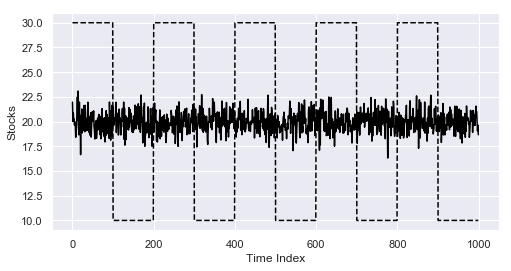

In [65]:
df = pd.read_csv('coint_vs_corr.csv', 
                 index_col=0)

df.columns = ['y1', 'y2']

score, pvalue, _ = coint(df['y1'], 
                         df['y2'])

print('Cointegration test p-value: ' + str(pvalue))
print('Correlation: ' + str(df['y1'].corr(df['y2'])))

df.iloc[:, 1].plot(figsize = (8,4), 
                   color = 'black', 
                   linestyle = '--');

plt.plot(df['y1'], 
         color='black') 

plt.xlabel('Time Index');
plt.ylabel('Stocks');
plt.show();

## Hedge 
[[go back to the top]](#Table-of-contents)

Short sales can be used to hedge long investments. Why?

- Short sale makes money if the asset sold loses value. In Fig.1 the short sale of $y_{1,t}$ made $\$20$ per share because the price went down by $\$20$
- Long purchase of $y_{1,t}$ will make money if asset increaes value
- One should long parts of the market and short others.

## General strategy
[[go back to the top]](#Table-of-contents)

Pairs trading maintains a hedged position across both assets $y_{1,t}$ and $y_{2,t}$. Possible scenarios:
- Both prices go down: we do not gain nor lose money
- If both go up, the same thing happens. 
- Our gains occur when the the spread of the two reverts to the mean. 
- We need to watch for when both stocks are far apart, short $y_{1,t}$ and long $y_{2,t}$ 
- We also watch for when they're close together, long $y_{2,t}$  and short $y_{1,t}$ .

## Code
[[go back to the top]](#Table-of-contents)

### Step 1

- `n` is the number of stocks
- `score_matrix` and `pvalue_matrix` are matrices with dimensions $n \times n$ where $n$ is the number of stocks. The former is initiated with zeros and the latter with ones. 
- `list(df.keys())` gives the list of columns' names for the `DataFrame` 
- The first of the two `for` loops is over the number of stocks `range(num_stocks)`. Then, fixing stock `i`, the next `for` loop scans the remaining stocks, testing for cointegration with `i` 
- The next line repopulates the two matrices defined before. E.g., the element `ij` of the new `pvalue_matrix` is the pvalue of the `ij` test 
- The conditional after that checks if the pair of series `ij` is cointegrated and adds it to the list `pairs` in case they are.
- The function returns the `score_matrix`, `pvalue_matrix` and the list of pairs of cointegrated stocks.

In [93]:
p=0.02

def find_pairs(df, p):
    
    num_stocks = df.shape[1]
    (score_matrix, pvalue_matrix) = (np.zeros((num_stocks, 
                                               num_stocks)), 
                                     np.ones((num_stocks, 
                                              num_stocks)))
    keys, pairs = list(df.keys()), []

    for i in range(num_stocks):
        
        for j in range(i+1, num_stocks):
            
            S1, S2 = df[keys[i]], df[keys[j]]
            
            (score_matrix[i, j], pvalue_matrix[i, j]) = (coint(S1, S2)[0], 
                                                         coint(S1, S2)[1])
            if pvalue < p:
                pairs.append((keys[i], 
                              keys[j]))
                
    return score_matrix, pvalue_matrix, pairs

In [105]:
print('The output of the function includes:\n')
print('1) The score matrix:\n\n', find_pairs(stocks, 0.02)[0],'\n')
print('2) The pvalue matrix:\n\n', find_pairs(stocks, 0.02)[1],'\n')
print('3) The list of cointegrated pairs:\n\n', find_pairs(stocks, 0.02)[2],'\n')

The output of the function includes:

1) The score matrix:

 [[ 0.         -8.62353887]
 [ 0.          0.        ]] 

2) The pvalue matrix:

 [[1.00000000e+00 7.96110919e-13]
 [1.00000000e+00 1.00000000e+00]] 

3) The list of cointegrated pairs:

 [('y1', 'y2')] 



In [ ]:
from backtester.dataSource.yahoo_data_source import YahooStockDataSource
ysds = YahooStockDataSource

start, end = '2007/12/01', '2017/12/01'
cachedFolderName, dataset = 'yahooData/', 'testPairsTrading'
ids = ['SPY','AAPL','ADBE',
       'SYMC','EBAY','MSFT',
       'QCOM','HPQ','JNPR',
       'AMD','IBM']

ds = ysds(cachedFolderName=cachedFolderName,
                            dataSetId=dataset,
                            instrumentIds=ids,
                            startDateStr=start,
                            endDateStr=end,
                            event='history')

In [128]:
data = ds.getBookDataByFeature()['adjClose']
data.head()

,SPY,AAPL,ADBE,SYMC,EBAY,MSFT,QCOM,HPQ,JNPR,AMD,IBM
2007-12-03,118.179031,22.645098,42.689999,12.552974,13.867846,25.335382,30.802353,15.650877,28.200424,9.66,79.256721
2007-12-04,117.122704,22.765379,43.320000,12.782257,13.859427,25.219950,30.339844,15.734653,28.237570,9.25,79.855850
2007-12-05,119.083336,23.485783,43.900002,12.825243,14.036196,26.282000,31.229469,16.029421,29.063990,8.91,81.001671
2007-12-06,120.787804,24.049175,44.540001,12.904058,14.212963,26.589848,31.260408,16.200075,29.017561,9.07,82.154961
2007-12-07,120.763748,24.599937,44.369999,12.689111,14.196128,26.574453,31.036068,16.085279,28.692566,9.05,81.525909


In [ ]:
scores, pvalues, pairs = find_pairs(data, p)

In [136]:
print('The pairs are:\n')
print(pairs)

The pairs are:

[('SPY', 'AAPL'), ('SPY', 'ADBE'), ('SPY', 'SYMC'), ('SPY', 'EBAY'), ('SPY', 'MSFT'), ('SPY', 'QCOM'), ('SPY', 'HPQ'), ('SPY', 'JNPR'), ('SPY', 'AMD'), ('SPY', 'IBM'), ('AAPL', 'ADBE'), ('AAPL', 'SYMC'), ('AAPL', 'EBAY'), ('AAPL', 'MSFT'), ('AAPL', 'QCOM'), ('AAPL', 'HPQ'), ('AAPL', 'JNPR'), ('AAPL', 'AMD'), ('AAPL', 'IBM'), ('ADBE', 'SYMC'), ('ADBE', 'EBAY'), ('ADBE', 'MSFT'), ('ADBE', 'QCOM'), ('ADBE', 'HPQ'), ('ADBE', 'JNPR'), ('ADBE', 'AMD'), ('ADBE', 'IBM'), ('SYMC', 'EBAY'), ('SYMC', 'MSFT'), ('SYMC', 'QCOM'), ('SYMC', 'HPQ'), ('SYMC', 'JNPR'), ('SYMC', 'AMD'), ('SYMC', 'IBM'), ('EBAY', 'MSFT'), ('EBAY', 'QCOM'), ('EBAY', 'HPQ'), ('EBAY', 'JNPR'), ('EBAY', 'AMD'), ('EBAY', 'IBM'), ('MSFT', 'QCOM'), ('MSFT', 'HPQ'), ('MSFT', 'JNPR'), ('MSFT', 'AMD'), ('MSFT', 'IBM'), ('QCOM', 'HPQ'), ('QCOM', 'JNPR'), ('QCOM', 'AMD'), ('QCOM', 'IBM'), ('HPQ', 'JNPR'), ('HPQ', 'AMD'), ('HPQ', 'IBM'), ('JNPR', 'AMD'), ('JNPR', 'IBM'), ('AMD', 'IBM')]


The heatmap of pvalues for the cointegrated pairs is below.

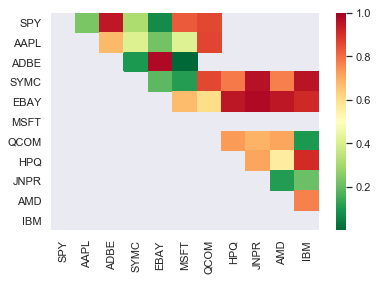

In [135]:
m = list(np.linspace(0,1,6))
sns.heatmap(pvalues, xticklabels=ids, 
            yticklabels=ids, cmap='RdYlGn_r', 
            mask = (pvalues >= 1-p))
plt.show();

In [163]:
def plot_price_ratios(df, pairs):
    
    for pair in pairs:
        
        score, pvalue, _ = coint(df[pair[0]], 
                             df[pair[1]])
        ratios = df[pair[0]]/df[pair[1]]
        zscore = (ratios - ratios.mean())/np.std(ratios)
        
        print('pair:', pair)
        zscore.plot(figsize=(10,5))
        plt.axhline(zscore.mean(), linestyle='dashed')
        plt.axhline(1.0, color='red')
        plt.axhline(-1.0, color='green')
        plt.legend(['Ratio z-score', 'Mean', '+1', '-1'])
        plt.show()
        
    return

The normalized ratio is shown below for all pairs. We see that though it roughly oscillates around the mean>

pair: ('SPY', 'AAPL')


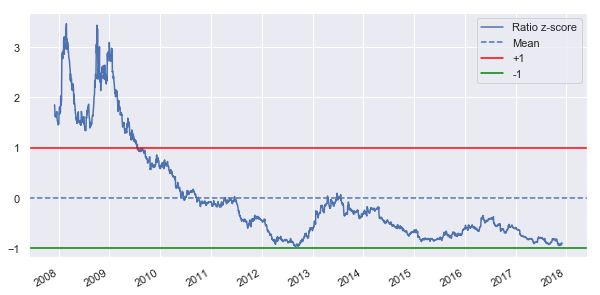

pair: ('SPY', 'ADBE')


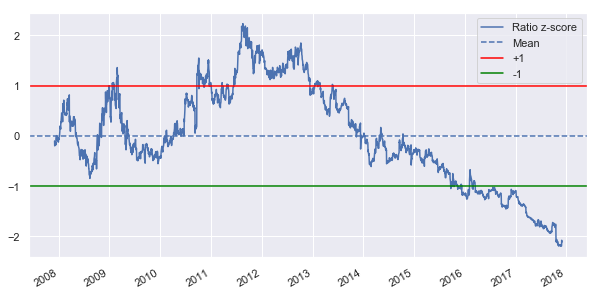

pair: ('SPY', 'SYMC')


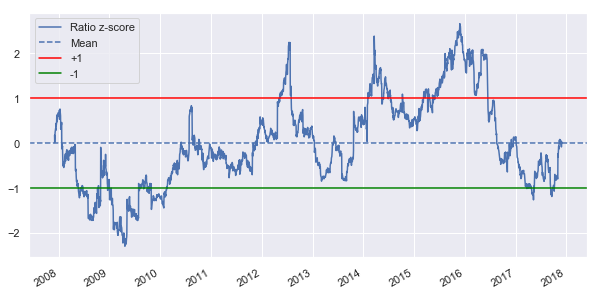

pair: ('SPY', 'EBAY')


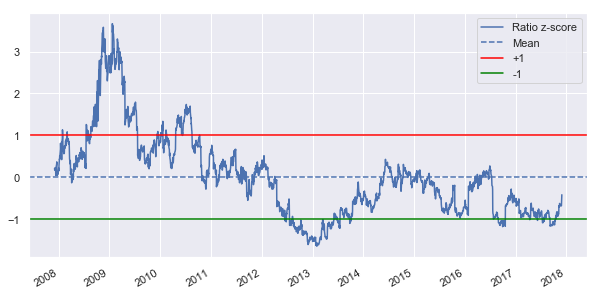

pair: ('SPY', 'MSFT')


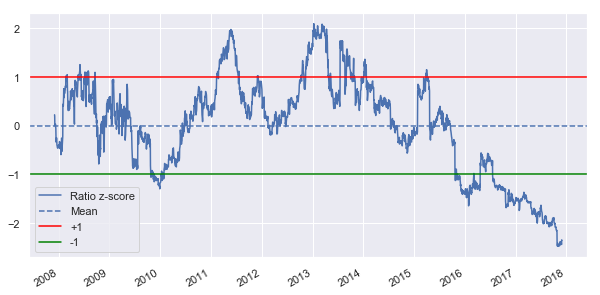

pair: ('SPY', 'QCOM')


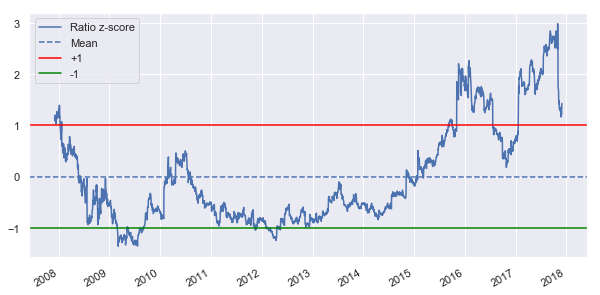

pair: ('SPY', 'HPQ')


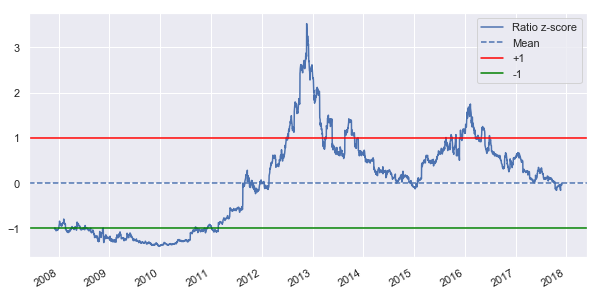

pair: ('SPY', 'JNPR')


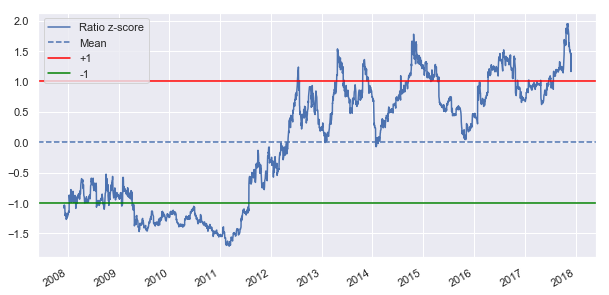

pair: ('SPY', 'AMD')


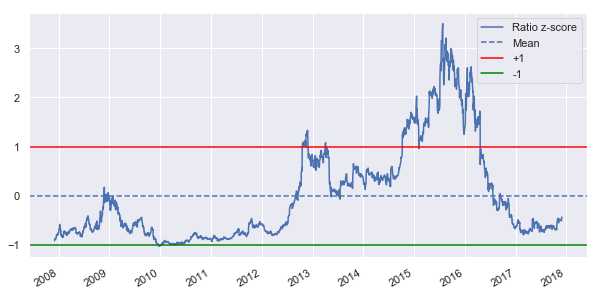

pair: ('SPY', 'IBM')


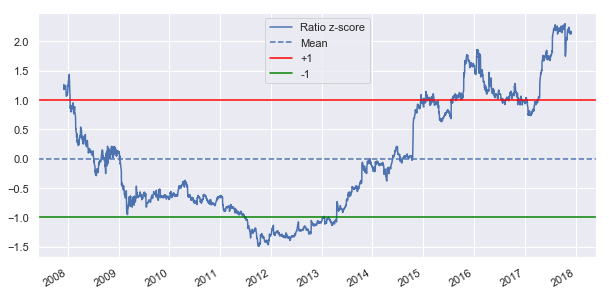

pair: ('AAPL', 'ADBE')


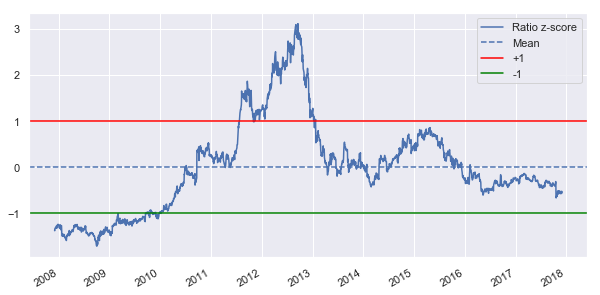

pair: ('AAPL', 'SYMC')


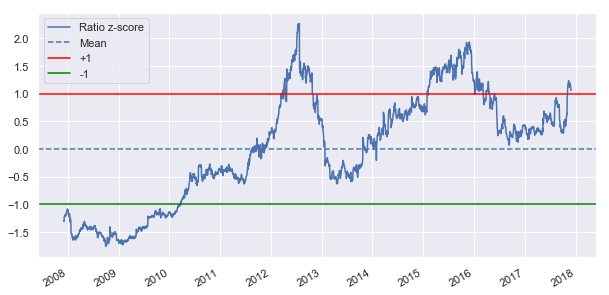

pair: ('AAPL', 'EBAY')


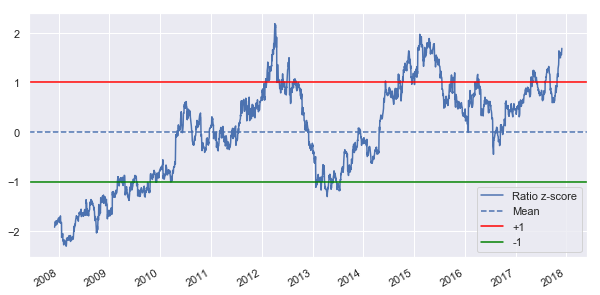

pair: ('AAPL', 'MSFT')


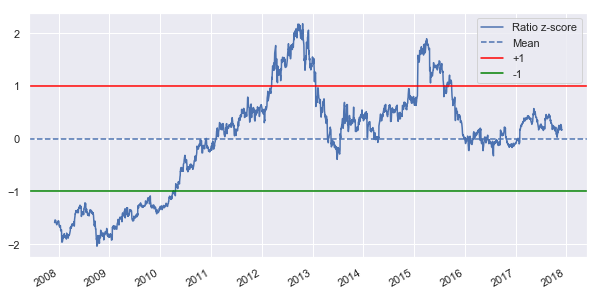

pair: ('AAPL', 'QCOM')


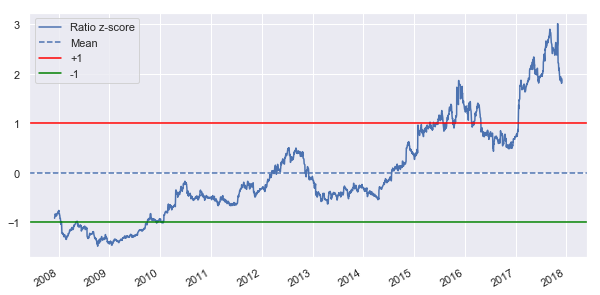

pair: ('AAPL', 'HPQ')


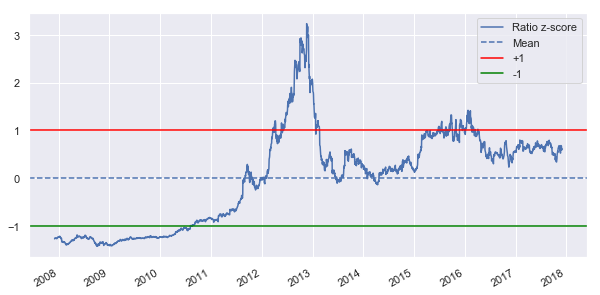

pair: ('AAPL', 'JNPR')


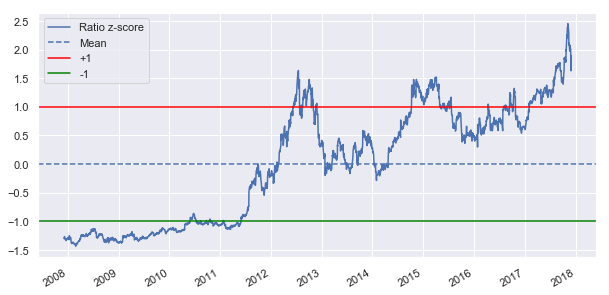

pair: ('AAPL', 'AMD')


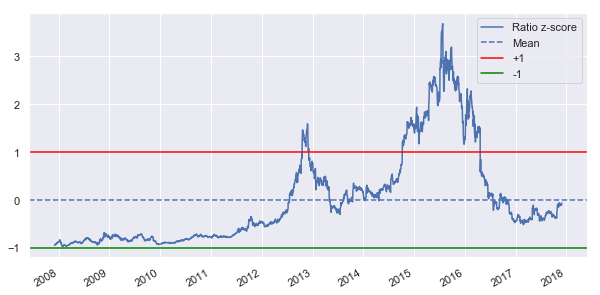

pair: ('AAPL', 'IBM')


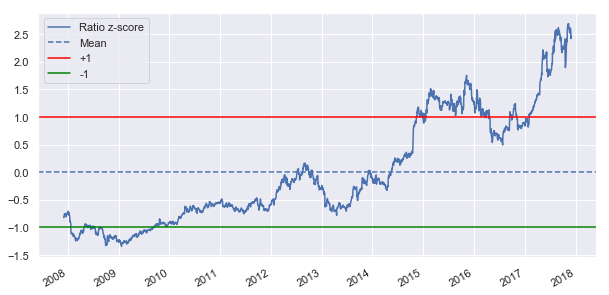

pair: ('ADBE', 'SYMC')


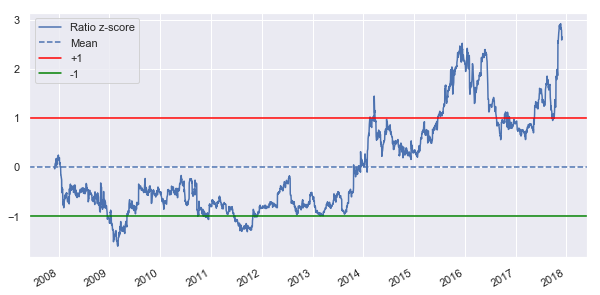

pair: ('ADBE', 'EBAY')


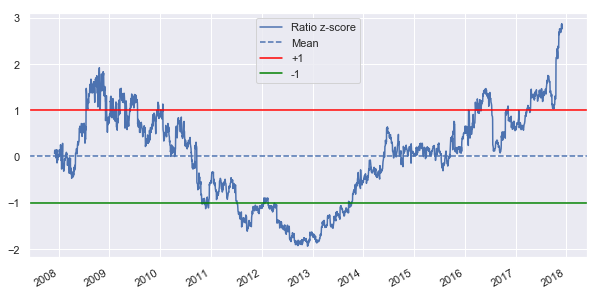

pair: ('ADBE', 'MSFT')


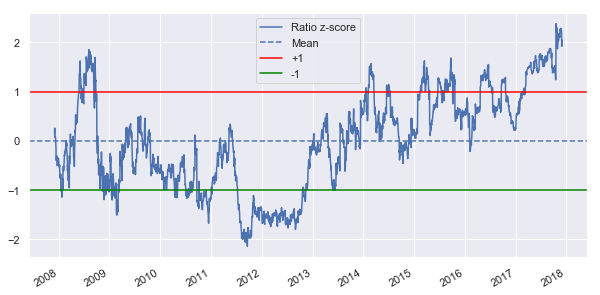

pair: ('ADBE', 'QCOM')


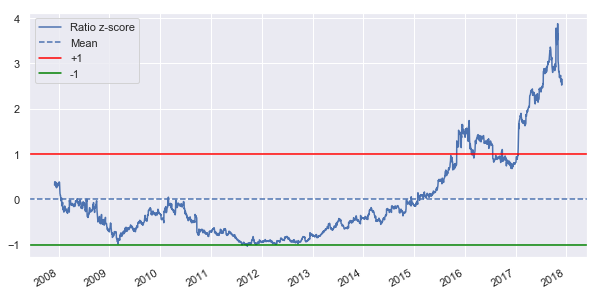

pair: ('ADBE', 'HPQ')


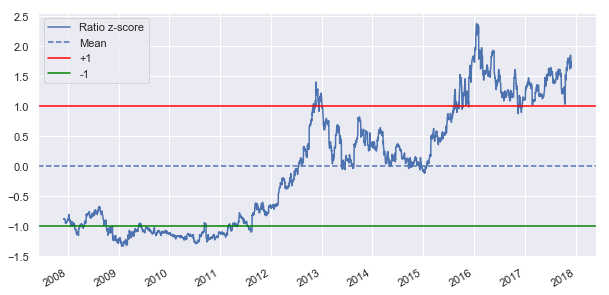

pair: ('ADBE', 'JNPR')


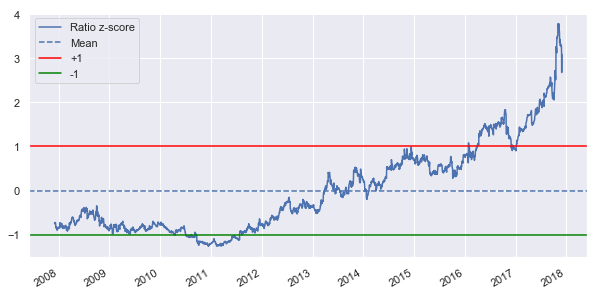

pair: ('ADBE', 'AMD')


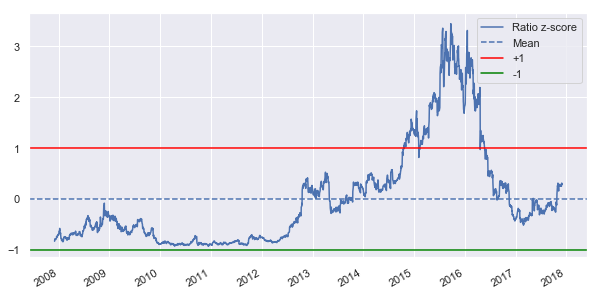

pair: ('ADBE', 'IBM')


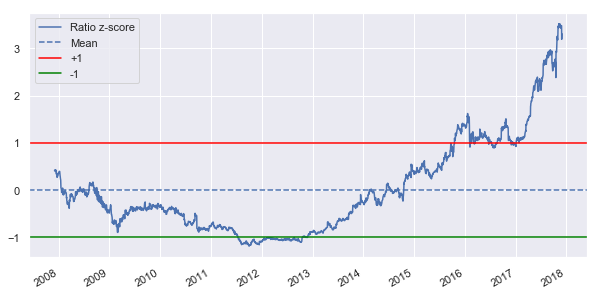

pair: ('SYMC', 'EBAY')


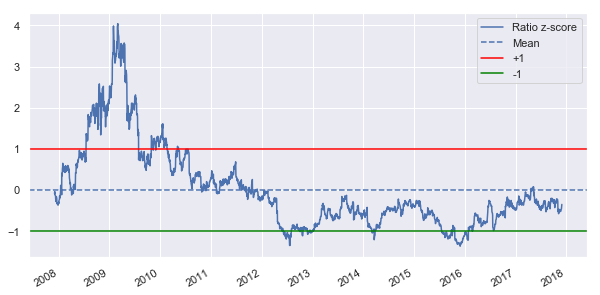

pair: ('SYMC', 'MSFT')


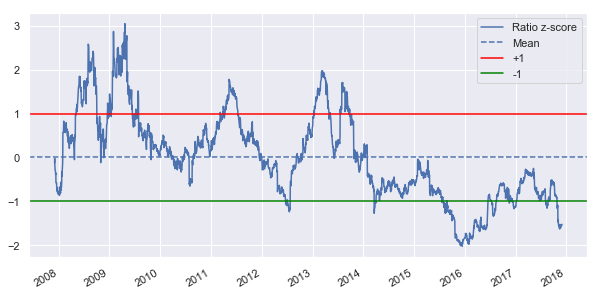

pair: ('SYMC', 'QCOM')


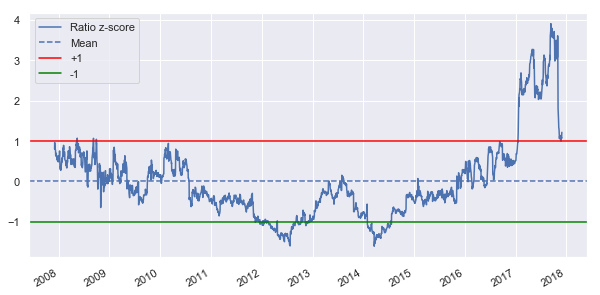

pair: ('SYMC', 'HPQ')


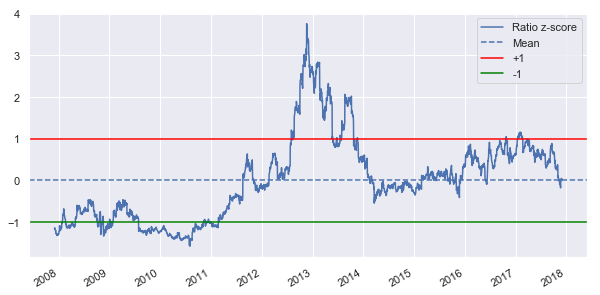

pair: ('SYMC', 'JNPR')


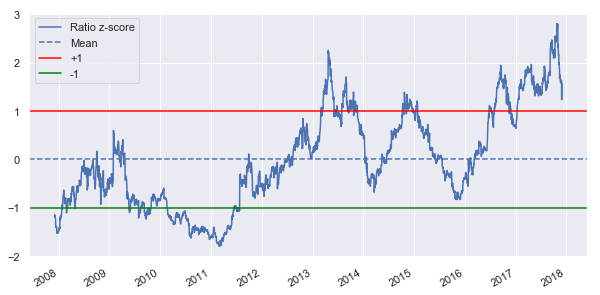

pair: ('SYMC', 'AMD')


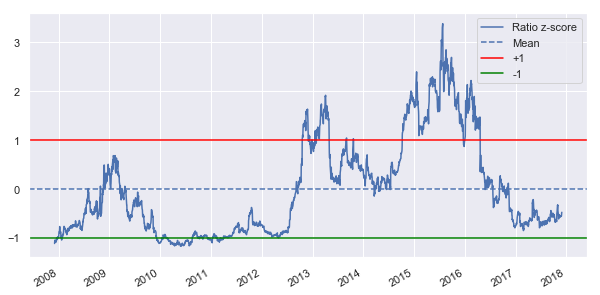

pair: ('SYMC', 'IBM')


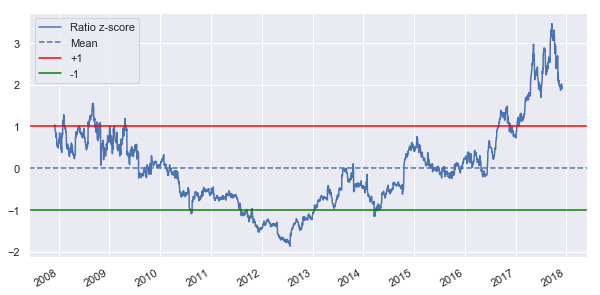

pair: ('EBAY', 'MSFT')


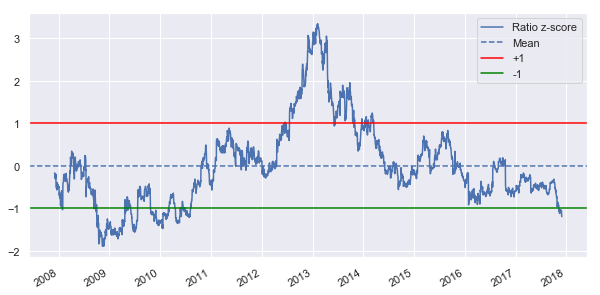

pair: ('EBAY', 'QCOM')


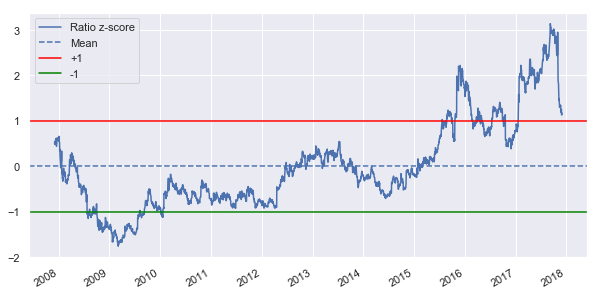

pair: ('EBAY', 'HPQ')


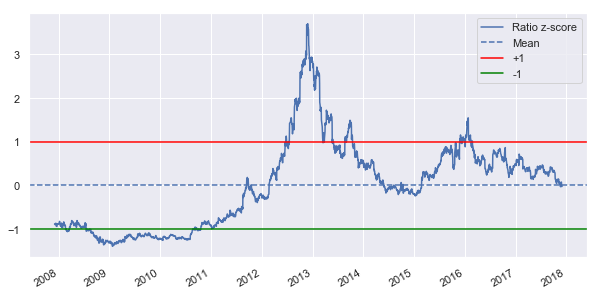

pair: ('EBAY', 'JNPR')


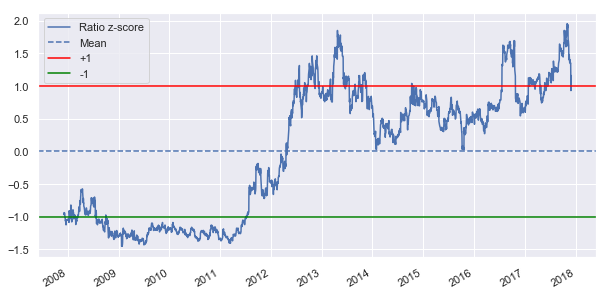

pair: ('EBAY', 'AMD')


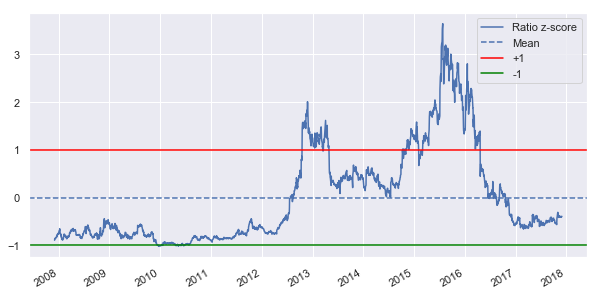

pair: ('EBAY', 'IBM')


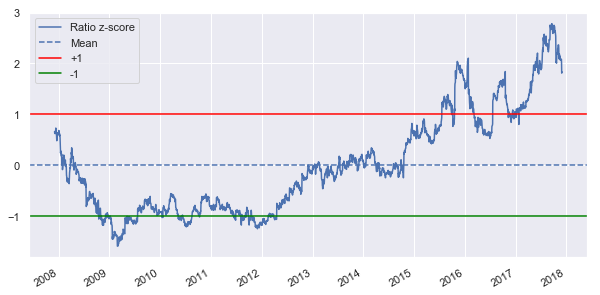

pair: ('MSFT', 'QCOM')


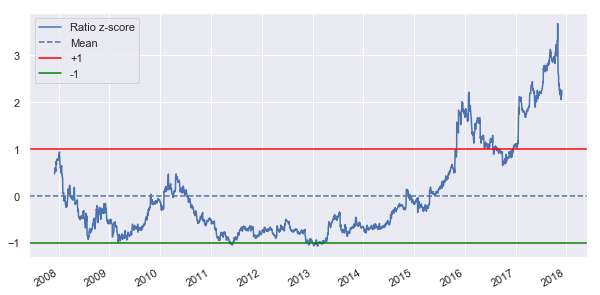

pair: ('MSFT', 'HPQ')


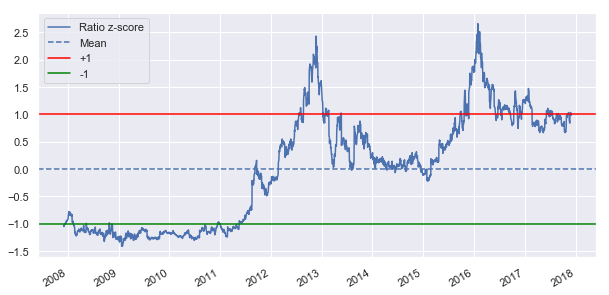

pair: ('MSFT', 'JNPR')


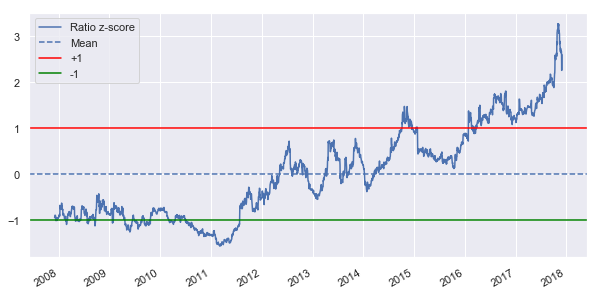

pair: ('MSFT', 'AMD')


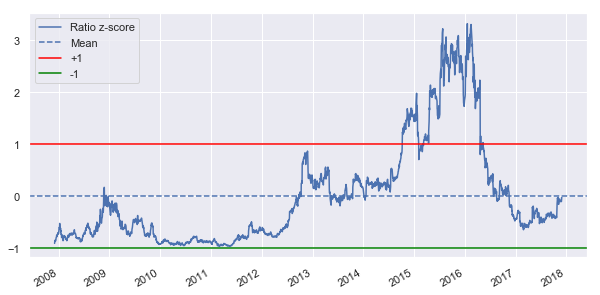

pair: ('MSFT', 'IBM')


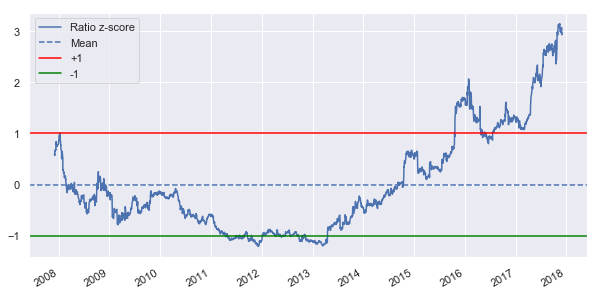

pair: ('QCOM', 'HPQ')


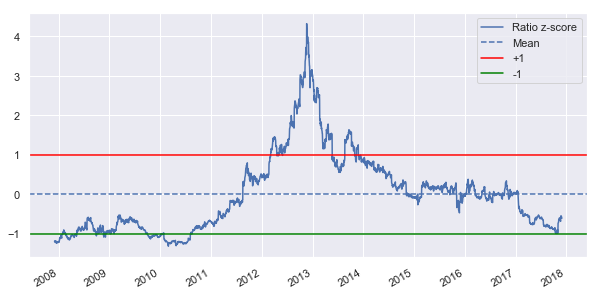

pair: ('QCOM', 'JNPR')


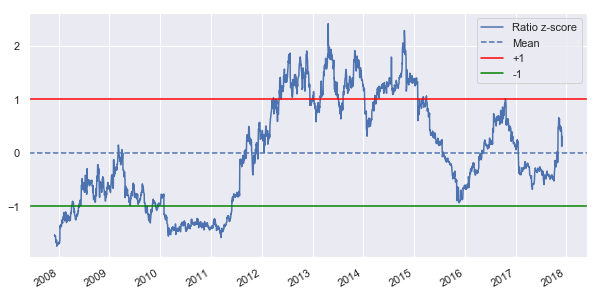

pair: ('QCOM', 'AMD')


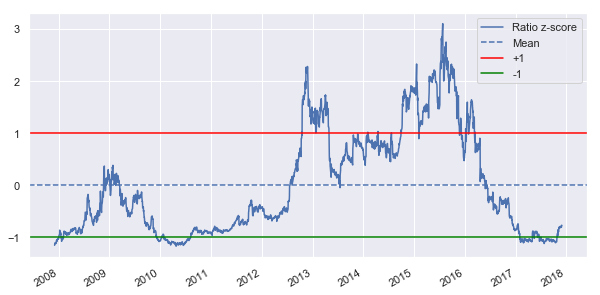

pair: ('QCOM', 'IBM')


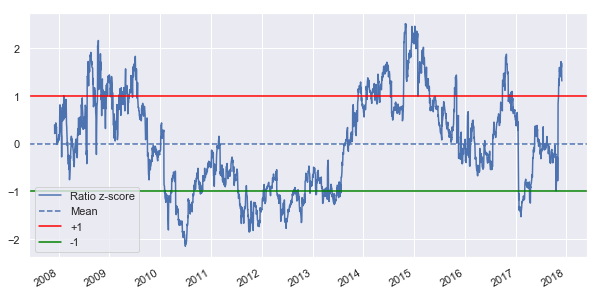

pair: ('HPQ', 'JNPR')


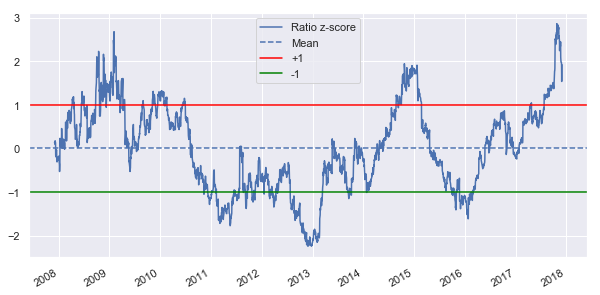

pair: ('HPQ', 'AMD')


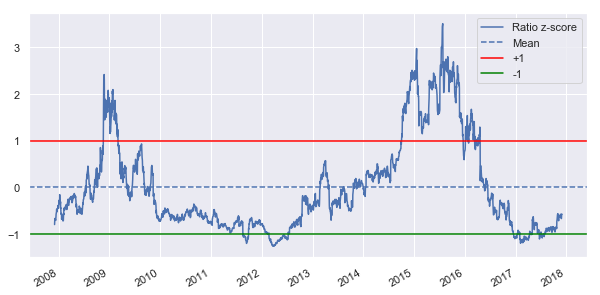

pair: ('HPQ', 'IBM')


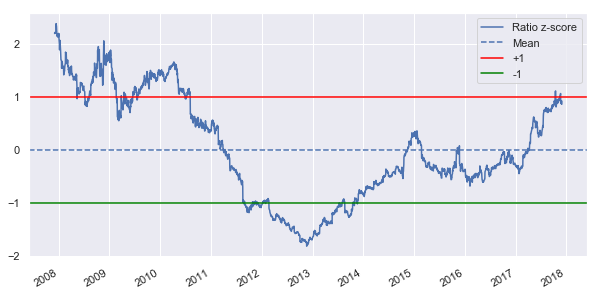

pair: ('JNPR', 'AMD')


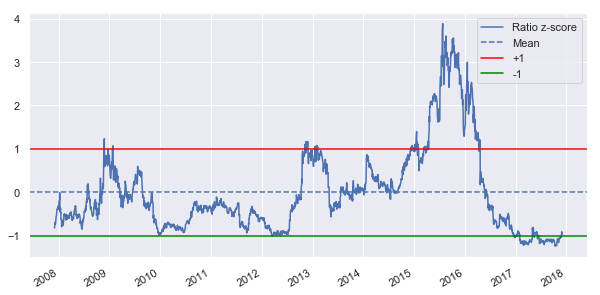

pair: ('JNPR', 'IBM')


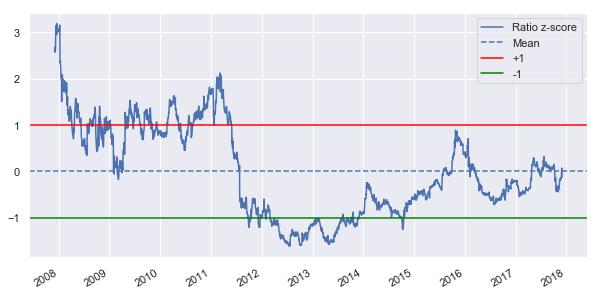

pair: ('AMD', 'IBM')


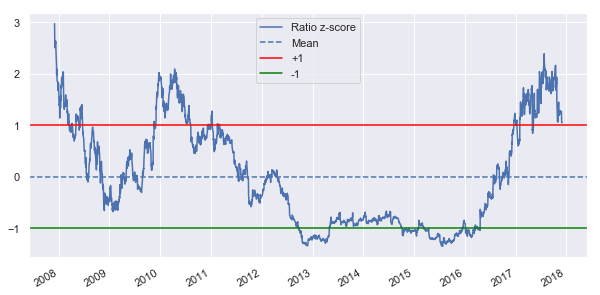

In [164]:
plot_price_ratios(data, pairs)

### Emails:

[Marcus Cabral](mailto:madriao@gmail.com)  

[Pedro Ferreira](mailto:pedrofer@openlink.com.br) 

[Marco Tavora](mailto:marcotav65@gmail.com)